<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/6States_labeling_CDC_Guideline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install wget
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=d8862ec518bff2107a30f4062a2af96224d58cda7888e4095a52eebca408e3f3
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Load County Population


In [5]:
county_population_US = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv',low_memory=False)
print(county_population_US.shape)

(3195, 4)


In [6]:
wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv('covid_county_population_usafacts.csv',low_memory=False)
print(county_population_US.shape)


(3195, 4)


In [7]:
county_population_US = county_population_US.rename(columns={"population": "county_population"})

In [8]:
county_population_US.head(2)

,countyFIPS,County Name,State,county_population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869


# Load Combined Dataset

## Data Preprocessing

In [72]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA/CA_combined_Sep25.csv',low_memory=False)
CA_combined_data.head()

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0


## 'New Cases/100k population'

In [73]:
CA_combined_data['New Cases/100k population'] = CA_combined_data['New cases']*100000/ CA_combined_data['population']
CA_combined_data.tail(2)

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population
9194,2020-08-20,6115,Yuba County,78668,0.0,0.0,0.0,0.0,-33.0,8.0,59.48,4.096,43,124.506204,1,0.669,0,0.000000
9195,2020-08-21,6115,Yuba County,78668,0.0,0.0,0.0,0.0,-33.0,10.0,84.31,5.820,61,124.506204,1,0.669,8,10.169319


## Merge with County Population

In [74]:
CA_combined_data = pd.merge(CA_combined_data,county_population_US,how='inner',left_on=['fips_x'],right_on=['countyFIPS'])
print(CA_combined_data.shape)

(9196, 22)


In [75]:
CA_combined_data.head(5)

,Date,fips_x,County Name_x,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,County Name_y,State,county_population
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.059833,6001,Alameda County,CA,1671329
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329


In [76]:
CA_combined_data = CA_combined_data.drop(['County Name_y'], axis = 1) 

In [77]:
CA_combined_data = CA_combined_data.rename(columns={"County Name_x": "County Name", "fips_x":"fips"})

In [78]:
CA_combined_data.head(3)

,Date,fips,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,State,county_population
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000,6001,CA,1671329
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000,6001,CA,1671329
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.059833,6001,CA,1671329


## Computing rolling average

17 no column  = New Cases/100k population

In [79]:
CA_combined_data.iloc[:,17]

0        0.000000
1        0.000000
2        0.059833
3        0.000000
4        0.000000
          ...    
9191     0.000000
9192    35.592617
9193    44.490771
9194     0.000000
9195    10.169319
Name: New Cases/100k population, Length: 9196, dtype: float64

In [80]:
CA_combined_data.columns

Index(['Date', 'fips', 'County Name', 'population', 'retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'New Cases/100k population', 'countyFIPS', 'State',
       'county_population'],
      dtype='object')

In [81]:
df = pd.DataFrame(columns=['Date', 'fips', 'County Name', 'population', 'retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'New Cases/100k population', 'countyFIPS', 'State',
       'county_population','rolling_avg_new_cases/100k'])


In [82]:
CA_counties = CA_combined_data['County Name'].unique()

for county in CA_counties:
  county_data = CA_combined_data[CA_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases/100k'] = county_data.iloc[:,17].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,fips,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,State,county_population,rolling_avg_new_cases/100k
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,NaN
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,NaN
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.059833,6001,CA,1671329,NaN
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,NaN
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,NaN


In [83]:
print(df.shape)
CA_combined_data.shape

(9196, 22)


(9196, 21)

In [84]:
CA_combined_data = df.copy()
CA_combined_data

,Date,fips,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,State,county_population,rolling_avg_new_cases/100k
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.000,0,0.000000,6001,CA,1671329,NaN
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.000,0,0.000000,6001,CA,1671329,NaN
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.000,1,0.059833,6001,CA,1671329,NaN
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.000,0,0.000000,6001,CA,1671329,NaN
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.000,0,0.000000,6001,CA,1671329,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9191,2020-08-17,6115,Yuba County,78668,0.0,0.0,0.0,0.0,-34.0,7.0,64.29,4.100,43,124.506204,1,0.669,0,0.000000,6115,CA,78668,20.338638
9192,2020-08-18,6115,Yuba County,78668,0.0,0.0,0.0,0.0,-32.0,8.0,54.39,4.944,52,124.506204,1,0.669,28,35.592617,6115,CA,78668,21.791398
9193,2020-08-19,6115,Yuba County,78668,0.0,0.0,0.0,0.0,-33.0,8.0,61.72,4.090,43,124.506204,1,0.669,35,44.490771,6115,CA,78668,25.968083
9194,2020-08-20,6115,Yuba County,78668,0.0,0.0,0.0,0.0,-33.0,8.0,59.48,4.096,43,124.506204,1,0.669,0,0.000000,6115,CA,78668,24.152133


In [85]:
CA_combined_data[CA_combined_data['Date'] == '2020-08-01'].head(4)

,Date,fips,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,State,county_population,rolling_avg_new_cases/100k
151,2020-08-01,6001,Alameda County,1671329,-44.0,-13.0,28.0,-49.0,-19.0,9.0,9.45,1.041,16,2261.547725,1,0.795,345,20.642255,6001,CA,1671329,9.863835
323,2020-08-01,6005,Amador County,39752,-9.0,12.0,0.0,0.0,-15.0,0.0,123.25,2.433,18,66.857277,1,0.655,10,25.155967,6005,CA,39752,19.406032
495,2020-08-01,6007,Butte County,219186,-21.0,2.0,39.0,0.0,-15.0,3.0,55.33,2.452,53,133.939112,1,0.626,0,0.000000,6007,CA,219186,11.927248
667,2020-08-01,6009,Calaveras County,45905,-31.0,0.0,0.0,0.0,-10.0,0.0,154.27,5.737,33,45.004461,1,0.562,0,0.000000,6009,CA,45905,8.091244


## clean data - fill NA 

In [86]:
CA_combined_data = CA_combined_data.fillna(0)
CA_combined_data.head(8)

,Date,fips,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,State,county_population,rolling_avg_new_cases/100k
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,0.000000
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,0.000000
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.059833,6001,CA,1671329,0.000000
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,0.000000
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,0.000000
5,2020-03-06,6001,Alameda County,1671329,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,0.000000
6,2020-03-07,6001,Alameda County,1671329,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.059833,6001,CA,1671329,0.017095
7,2020-03-08,6001,Alameda County,1671329,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.000000,6001,CA,1671329,0.017095


## Apply CDC Guideline for all counties

https://www.cdc.gov/coronavirus/2019-ncov/travelers/how-level-is-determined.html

In [87]:
county_names = CA_combined_data['County Name'].unique()

In [88]:
CA_combined_data[CA_combined_data['County Name']== 'Alameda County'].county_population.unique()[0]

1671329

In [89]:
CA_combined_data[CA_combined_data['county_population'] < 300000]['County Name'].shape

(5412,)

* Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
* Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
* Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
* Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity

In [90]:
for county in county_names:
    print('county name: ',county)
    county_population = CA_combined_data[CA_combined_data['County Name']== county].county_population.unique()[0]
    county_data = CA_combined_data[CA_combined_data['County Name']== county]
    new_cases_100k_la_list = county_data['New Cases/100k population'].values
    #rolling_avg_new_cases/100k_list = county_data['rolling_avg_new_cases/100k'].values
    

    diffArr = np.diff(new_cases_100k_la_list)
    growth_values =[]
    growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
    growth_values.extend(diffArr)
    county_data['growth_values'] = growth_values

    minVal = np.min(growth_values)
    maxVal = np.max(growth_values)
    meanVal= np.mean(growth_values, axis=0)
    stdVal = np.std(growth_values, axis=0)

#implementing cdc guideline-CA color code
#Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
#Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
#Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
#Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity
    for index, row in (county_data.iterrows()):
      i = row['rolling_avg_new_cases/100k']
      if i > 7 :
        label = 'widespread'
      elif (i <= 7) and (i >= 4):
        label = 'substantial'
      elif (i < 4) and (i >= 1):
        label = 'moderate'
      elif i < 1 :
        label = 'minimal'
          
    
      date = row['Date']
      #print(i,county, date, label)

      df_index = (CA_combined_data['County Name'] == county) & (CA_combined_data['Date'] == date) 
      #print(df_weekData)
      CA_combined_data.loc[df_index,'growth_label'] = label
    #break

county name:  Alameda County


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


county name:  Amador County
county name:  Butte County
county name:  Calaveras County
county name:  Colusa County
county name:  Contra Costa County
county name:  Del Norte County
county name:  El Dorado County
county name:  Fresno County
county name:  Glenn County
county name:  Humboldt County
county name:  Imperial County
county name:  Inyo County
county name:  Kern County
county name:  Kings County
county name:  Lake County
county name:  Lassen County
county name:  Los Angeles County
county name:  Madera County
county name:  Marin County
county name:  Mariposa County
county name:  Mendocino County
county name:  Merced County
county name:  Mono County
county name:  Monterey County
county name:  Napa County
county name:  Nevada County
county name:  Orange County
county name:  Placer County
county name:  Plumas County
county name:  Riverside County
county name:  Sacramento County
county name:  San Benito County
county name:  San Bernardino County
county name:  San Diego County
county na

In [91]:
print(CA_combined_data[CA_combined_data['growth_label'] == 'widespread'].shape)
print(CA_combined_data[CA_combined_data['growth_label'] == 'substantial'].shape)
print(CA_combined_data[CA_combined_data['growth_label'] == 'moderate'].shape)
print(CA_combined_data[CA_combined_data['growth_label'] == 'minimal'].shape)


(2731, 23)
(922, 23)
(2362, 23)
(3181, 23)


In [106]:
#to show all rows
pd.set_option('display.max_rows', None)

In [108]:
CA_combined_data.groupby(['County Name','growth_label']).size().reset_index(name='row_count').sort_values(by=['County Name','growth_label','row_count'], ascending=False)

,County Name,growth_label,row_count
213,Yuba County,widespread,52
212,Yuba County,substantial,3
211,Yuba County,moderate,19
210,Yuba County,minimal,98
209,Yolo County,widespread,58
208,Yolo County,substantial,7
207,Yolo County,moderate,41
206,Yolo County,minimal,66
205,Ventura County,widespread,60
204,Ventura County,substantial,12


## Verifying with plot

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


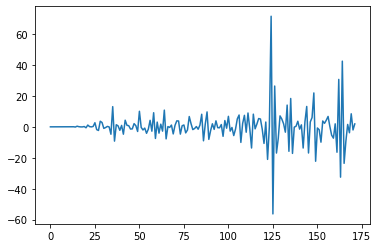

(120, 24)


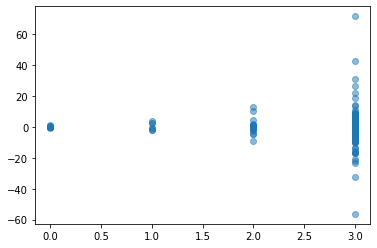

In [92]:
alameda_data = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']

new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
diffArr = np.diff(new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


Using rolling_avg_new_cases/100k

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


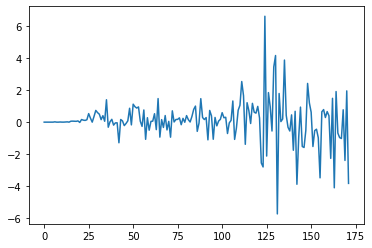

(120, 24)


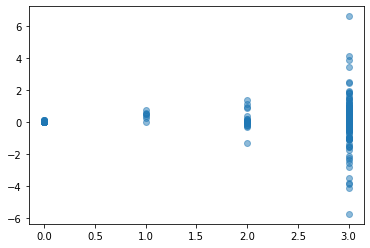

In [93]:
alameda_data = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']

rollavg_new_cases_100k_la_list = alameda_data['rolling_avg_new_cases/100k'].values
diffArr = np.diff(rollavg_new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
rollavg_new_cases_100k_la_list = alameda_data['rolling_avg_new_cases/100k'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()

## verifying Rolling average with visualizations -Los Angeles County

In [94]:
CA_combined_data.Date.unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-

In [110]:
date_list_aug = ['2020-08-01',
       '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
       '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
       '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
       '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
       '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21']

date_list = ['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
       '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
       '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
       '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
       '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
       '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
       '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
       '2020-07-29', '2020-07-30', '2020-07-31']

### ['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]

In [115]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'widespread')]['Date'].unique()

array(['2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
       '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
       '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
       '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
       '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
       '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24',
       '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
       '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
       '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
       '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
       '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
       '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
       '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22',
       '2020-06-23', '2020-06-24', '2020-06-25', '2020-

In [116]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'substantial')]['Date'].unique()

array(['2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22'],
      dtype=object)

In [117]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'moderate')]['Date'].unique()

array(['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
       '2020-03-30', '2020-03-31', '2020-04-01'], dtype=object)

In [118]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'minimal')]['Date'].unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25'], dtype=object)

In [111]:
los_angeles_county = CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & CA_combined_data['Date'].isin(date_list)]
print(los_angeles_county.shape)
los_angeles_county.head()

(31, 23)


,Date,fips,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,State,county_population,rolling_avg_new_cases/100k,growth_label
3044,2020-07-01,6037,Los Angeles County,10039107,-26.0,-9.0,-4.0,-37.0,-40.0,14.0,0.67,2.844,43,2473.978284,1,0.786,1815,18.079297,6037,CA,10039107,22.813640,widespread
3045,2020-07-02,6037,Los Angeles County,10039107,-25.0,-3.0,-3.0,-36.0,-42.0,14.0,7.05,3.032,45,2473.978284,1,0.786,2127,21.187143,6037,CA,10039107,23.074050,widespread
3046,2020-07-03,6037,Los Angeles County,10039107,-27.0,5.0,-3.0,-40.0,-58.0,19.0,4.81,2.752,41,2473.978284,1,0.786,14,0.139455,6037,CA,10039107,20.512638,widespread
3047,2020-07-04,6037,Los Angeles County,10039107,-51.0,-9.0,-35.0,-44.0,-36.0,12.0,-24.75,1.081,16,2473.978284,1,0.786,20,0.199221,6037,CA,10039107,17.703624,widespread
3048,2020-07-05,6037,Los Angeles County,10039107,-40.0,-21.0,-24.0,-43.0,-25.0,9.0,-21.24,0.577,8,2473.978284,1,0.786,7198,71.699604,6037,CA,10039107,24.341949,widespread


In [112]:
los_angeles_county.growth_label.unique()

array(['widespread'], dtype=object)

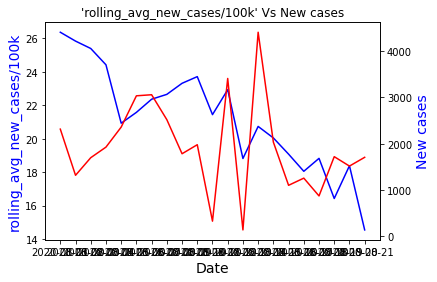

In [97]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New cases")
plt.xticks(rotation=90)
plt.show()


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text major ticklabel objects>)

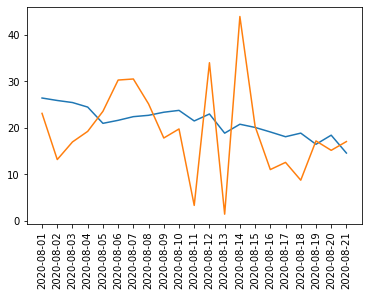

In [98]:
x = los_angeles_county['Date']
y1 = los_angeles_county['rolling_avg_new_cases/100k'] 
y2 = los_angeles_county['New Cases/100k population']


plt.plot(x,y1)
plt.plot(x,y2)
plt.xticks(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


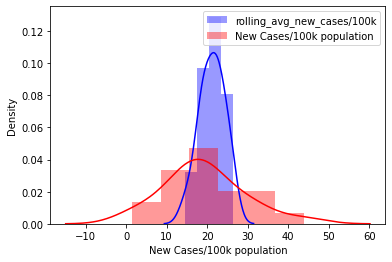

In [99]:
sns.distplot( (los_angeles_county['rolling_avg_new_cases/100k'] ) , color="blue", label='rolling_avg_new_cases/100k')
sns.distplot( los_angeles_county['New Cases/100k population'] , color="red", label='New Cases/100k population')
plt.legend()
 
plt.show()

In [100]:
suffolk_county = CA_combined_data[CA_combined_data['County Name'] == 'Santa Clara County']

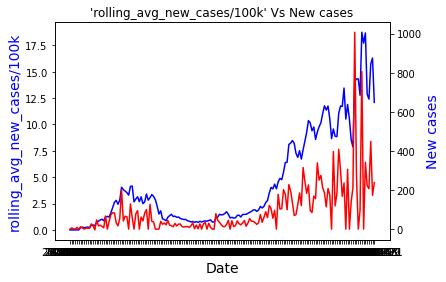

In [101]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New cases")

plt.show()

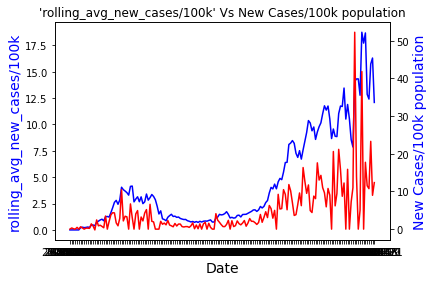

In [102]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New Cases/100k population"],color="red")
ax2.set_ylabel("New Cases/100k population",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New Cases/100k population")

plt.show()

## Export to CSV file to drive

In [103]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA/'
filename = 'CA_labeledData_CDC_Guideline_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_data.to_csv(location+filename,index=False)

CA_labeledData_CDC_Guideline_Nov01.csv


# Loading Inertia

In [65]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/County_Oct13.csv',low_memory=False)
maryland_sd_inertia.head()


,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,1/1/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,1/2/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,1/3/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,1/4/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,1/5/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


## Load USA State Fips Code

In [66]:
state_fips_code = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/US_State_FIPSCodes.csv',low_memory=False)
state_fips_code.head()

,State,Postal Code,STFIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


## Fixdate column of Social Distancing inertia

In [67]:
def fixDate(x, appendTwenty):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  if appendTwenty == True:
    return '20'+y+'-'+m+'-'+d
  else:
      return y+'-'+m+'-'+d

In [68]:
maryland_sd_inertia['date'] = maryland_sd_inertia['date'].apply(lambda x: fixDate(x,False))
maryland_sd_inertia.reset_index(drop=True)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901749,56045,Weston County,56,40,20,3.00,27.4,10.3,172.4,0.04,2.96,3,6967,-16.3,2020-10-09,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.50,0,38.319241,6.6,191.28,1.32,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901750,56045,Weston County,56,37,22,3.37,26.1,10.3,90.4,0.11,3.26,4,6967,-7.8,2020-10-10,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.65,0,38.321286,6.7,191.49,1.33,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901751,56045,Weston County,56,42,26,2.70,24.5,13.1,71.9,0.06,2.64,0,6967,-25.3,2020-10-11,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3349,5.81,0,38.323483,6.9,191.76,1.33,3,25,9.69,0,1.2,9.3,18.5,1.51,0.96
901752,56045,Weston County,56,26,19,3.05,25.3,9.9,102.7,0.04,3.00,0,6967,-15.2,2020-10-12,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.1914,6.08,0,38.324928,7.0,192.09,1.33,3,24,9.69,0,1.2,9.3,18.5,1.51,0.96


In [69]:
maryland_sd_inertia.head(3)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [70]:
maryland_sd_inertia.columns

Index(['CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemploy

## Assign State Name

California, New York, Texas, Iowa, Wisconsin, Colorado

In [71]:
maryland_sd_inertia = pd.merge(state_fips_code,maryland_sd_inertia,how='inner',left_on=['STFIPS'],right_on=['STFIPS'])
print(maryland_sd_inertia.shape)

maryland_sd_inertia.head(2)

(901467, 45)


,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,Alabama,AL,1,1001,Autauga County,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,Alabama,AL,1,1001,Autauga County,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


## Filter Data for 6 States

In [72]:
state_list = ['California', 'New York', 'Texas', 'Iowa', 'Wisconsin', 'Colorado']

maryland_sd_inertia_6states = maryland_sd_inertia[maryland_sd_inertia['State'].isin(state_list)]
print(maryland_sd_inertia_6states.head(3) )

            State Postal Code  ...  Cumulative inflation rate  COVID death rate
53382  California          CA  ...                        0.3               0.0
53383  California          CA  ...                        0.3               0.0
53384  California          CA  ...                        0.3               0.0

[3 rows x 45 columns]


In [73]:
maryland_sd_inertia_6states.State.unique()

array(['California', 'Colorado', 'Iowa', 'New York', 'Texas', 'Wisconsin'],
      dtype=object)

## 'New Cases/10k population'

In [74]:
maryland_sd_inertia_6states.head(2)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
53382,California,CA,6,6001,Alameda County,50,32,2.41,26.1,0.4,38.0,0.2,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
53383,California,CA,6,6001,Alameda County,24,22,3.17,27.9,0.4,38.5,0.5,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0


In [75]:
maryland_sd_inertia_6states['New Cases/10k population'] = maryland_sd_inertia_6states['New COVID cases']*10000/ maryland_sd_inertia_6states['Population']
maryland_sd_inertia_6states.tail(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New Cases/10k population
894864,Wisconsin,WI,55,55141,Wood County,32,23,2.87,35.1,1.0,40.9,0.53,2.34,18,73055,-17.4,2020-10-12,0.2,26,53473,0.6,2.9,49.21,91,54,145,3.01,0.27,0.045,0.3376,11.07,0,50.300740,9.4,293.46,15.13,209,534,18.65,133,2.1,9.9,19.7,2.1,1.33,2.463897
894865,Wisconsin,WI,55,55141,Wood County,31,21,3.02,32.5,0.6,44.6,0.53,2.49,20,73055,-12.1,2020-10-13,0.2,26,53473,0.6,2.9,49.21,91,54,145,3.01,0.27,0.045,0.2920,11.35,0,48.555679,9.5,295.98,15.32,174,544,18.65,133,2.1,9.9,19.7,2.1,1.33,2.737663


## Apply CDC Guideline for all counties

In [76]:
county_names = maryland_sd_inertia_6states['CTNAME'].unique()

In [79]:
for county in county_names:
    print('county :',county)
    county_population = maryland_sd_inertia_6states[maryland_sd_inertia_6states['CTNAME']== county].Population.unique()[0]
    county_data = maryland_sd_inertia_6states[maryland_sd_inertia_6states['CTNAME']== county]
    new_cases_10k_la_list = county_data['New Cases/10k population'].values
    diffArr = np.diff(new_cases_10k_la_list)
    growth_values =[]
    growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
    growth_values.extend(diffArr)
    county_data['growth_values'] = growth_values

    minVal = np.min(growth_values)
    maxVal = np.max(growth_values)
    meanVal= np.mean(growth_values, axis=0)
    stdVal = np.std(growth_values, axis=0)

    #implementing cdc guideline
    for index, row in (county_data.iterrows()):

      i = row['growth_values']
      if county_population > 300000:
          if i > 3 :
            label = 'high'
          # 1.5-3
          elif (i <= 3) and (i >= 1.5):
            label = 'moderate'
          elif i < 1.5 :
            label = 'low'
      #need discussion here
      elif county_population <= 300000:
          if i > 3 :
            label = 'high'
          # 1.5-3
          elif (i <= 3) and (i >= 1.5):
            label = 'moderate'
          elif i < 1.5 :
            label = 'low'
    
      date = row['date']
      #print(i,county, date, label)

      df_index = (maryland_sd_inertia_6states['CTNAME'] == county) & (maryland_sd_inertia_6states['date'] == date) 
      #print(df_weekData)
      maryland_sd_inertia_6states.loc[df_index,'growth_label'] = label
    #break
    
    

county : Alameda County


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

county : Alpine County
county : Amador County
county : Butte County
county : Calaveras County
county : Colusa County
county : Contra Costa County
county : Del Norte County
county : El Dorado County
county : Fresno County
county : Glenn County
county : Humboldt County
county : Imperial County
county : Inyo County
county : Kern County
county : Kings County
county : Lake County
county : Lassen County
county : Los Angeles County
county : Madera County
county : Marin County
county : Mariposa County
county : Mendocino County
county : Merced County
county : Modoc County
county : Mono County
county : Monterey County
county : Napa County
county : Nevada County
county : Orange County
county : Placer County
county : Plumas County
county : Riverside County
county : Sacramento County
county : San Benito County
county : San Bernardino County
county : San Diego County
county : San Francisco County
county : San Joaquin County
county : San Luis Obispo County
county : San Mateo County
county : Santa Bar

KeyboardInterrupt: ignored

### Verifying the labeling with plot

['flat_growth' 2 'mild_decrement' 3 'drastic_growth' 1 'drastic_decrement'
 0 'mild_growth' 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


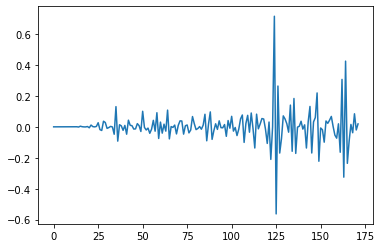

(102, 20)


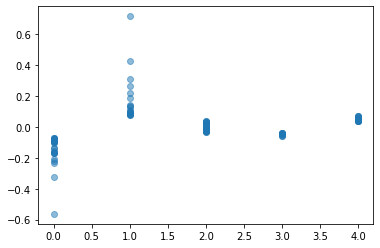

In [ ]:
alameda_data = maryland_sd_inertia_6states[maryland_sd_inertia_6states['County Name'] == 'Los Angeles County']

new_cases_10k_la_list = alameda_data['New Cases/10k population'].values
diffArr = np.diff(new_cases_10k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_10k_la_list = alameda_data['New Cases/10k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'high']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


## Export to csv

In [ ]:
print(maryland_sd_inertia_6states[maryland_sd_inertia_6states['growth_label'] == 'high'].shape)
print(maryland_sd_inertia_6states[maryland_sd_inertia_6states['growth_label'] == 'moderate'].shape)
print(maryland_sd_inertia_6states[maryland_sd_inertia_6states['growth_label'] == 'low'].shape)


(326, 22)
(316, 22)
(8554, 22)


In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/'
filename = '6states_sd_inertia_labeledData_CDC_Guideline_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
maryland_sd_inertia_6states.to_csv(location+filename,index=False)

CA_sd_inertia_labeledData_Oct11.csv


## Apply for all counties -UNUSED

In [62]:
county_names = maryland_sd_inertia['CTNAME'].unique()

In [ ]:
for county in county_names:
    print('county :',county)
    county_data = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME']== county]
    new_cases_1k_la_list = county_data['New cases/1000 people'].values
    diffArr = np.diff(new_cases_1k_la_list)
    growth_values =[]
    growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
    growth_values.extend(diffArr)
    county_data['growth_values'] = growth_values

    minVal = np.min(growth_values)
    maxVal = np.max(growth_values)
    meanVal= np.mean(growth_values, axis=0)
    stdVal = np.std(growth_values, axis=0)
    debug = False
    if debug:
      print("min : ",minVal)
      print("max : ",maxVal)
      print('Mean: ', np.mean(growth_values, axis=0))
      print('Standard Deviation:', np.std(growth_values, axis=0))
      print('. (meanVal + (stdVal * 1) / 3). ',(meanVal + (stdVal * 1) / 3))
      print('. (meanVal - (stdVal * 1) / 3). ',(meanVal - (stdVal * 1) / 3))
      print('. (meanVal + (stdVal * 2) / 3). ',(meanVal + (stdVal * 2) / 3))
      print('. (meanVal - (stdVal * 2) / 3). ',(meanVal - (stdVal * 2) / 3))
      print('. (meanVal + (stdVal * 3) / 3). ',(meanVal + (stdVal * 3) / 3))
      print('. (meanVal - (stdVal * 3) / 3). ',(meanVal - (stdVal * 3) / 3))
      print("min : ",minVal)
      print('. (meanVal - (stdVal * 1) / 2). ',(meanVal - (stdVal * 1) / 2))
      print('. (meanVal - (stdVal * 2) / 2). ',(meanVal - (stdVal * 2) / 2))
      print('. (meanVal - (stdVal * 3) / 2). ',(meanVal - (stdVal * 3) / 2))

      print("max : ",maxVal)
      print('. (meanVal + (stdVal * 1) / 2). ',(meanVal + (stdVal * 1) / 2))
      print('. (meanVal + (stdVal * 2) / 2). ',(meanVal + (stdVal * 2) / 2))
      print('. (meanVal + (stdVal * 3) / 2). ',(meanVal + (stdVal * 3) / 2))

      print("min : ",minVal)
      print('. (meanVal - (stdVal * 1)). ',(meanVal - (stdVal * 1)))
      print('. (meanVal - (stdVal * 2)). ',(meanVal - (stdVal * 2)))
      print('. (meanVal - (stdVal * 3)). ',(meanVal - (stdVal * 3)))

      print("max : ",maxVal)
      print('. (meanVal + (stdVal * 1)). ',(meanVal + (stdVal * 1)))
      print('. (meanVal + (stdVal * 2)). ',(meanVal + (stdVal * 2)))
      print('. (meanVal + (stdVal * 3)). ',(meanVal + (stdVal * 3)))

    meanVal= np.mean(new_cases_1k_la_list, axis=0)
    stdVal = np.std(new_cases_1k_la_list, axis=0)
    #print('Mean: ', np.mean(new_cases_1k_la_list, axis=0))
    #print('Standard Deviation:', np.std(new_cases_1k_la_list, axis=0))
    for index, row in (county_data.iterrows()):

      i = row['growth_values']

      if (i > (meanVal + (stdVal * 1) / 3)):
          #print("Label: ", i, "drastic_growth")
          label =  'drastic_growth'
      elif ( i > (meanVal + (stdVal * 2) /3) and i <= (meanVal + (stdVal * 1) / 3)):
          #print("Label: ", i, "mild_growth")
          label =  'mild_growth'
      elif (i >= (meanVal - (stdVal * 1) / 3) and i <= meanVal and i <= (meanVal + (stdVal * 1) / 3)):
          #print("Label: ", i, "flat_growth")
          label = 'flat_growth'
      elif (i < (meanVal - (stdVal * 1) / 3) and i >= (meanVal - (stdVal * 2) / 3)):
          #print("Label: ", i, "mild_decrement")
          label = 'mild_decrement'
      elif (i < (meanVal - (stdVal * 2) / 3)):
          #print("Label: ", i, "drastic_decrement")
          label = 'drastic_decrement'
    
      date = row['Date']
      #print(i,county, date, label)

      df_index = (CA_combined_sd_inertia_data['CTNAME'] == county) & (CA_combined_sd_inertia_data['Date'] == date) 
      #print(df_weekData)
      CA_combined_sd_inertia_data.loc[df_index,'growth_label'] = label
    #break
    

county : Alameda County


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


county : Alpine County
county : Amador County
county : Butte County
county : Calaveras County
county : Colusa County
county : Contra Costa County
county : Del Norte County
county : El Dorado County
county : Fresno County
county : Glenn County
county : Humboldt County
county : Imperial County
county : Inyo County
county : Kern County
county : Kings County
county : Lake County
county : Lassen County
county : Los Angeles County
county : Madera County
county : Marin County
county : Mariposa County
county : Mendocino County
county : Merced County
county : Modoc County
county : Mono County
county : Monterey County
county : Napa County
county : Nevada County
county : Orange County
county : Placer County
county : Plumas County
county : Riverside County
county : Sacramento County
county : San Benito County
county : San Bernardino County
county : San Diego County
county : San Francisco County
county : San Joaquin County
county : San Luis Obispo County
county : San Mateo County
county : Santa Bar

### Verifying the labeling with plot

['flat_growth' 2 'mild_decrement' 3 'drastic_growth' 1 'drastic_decrement'
 0 'mild_growth' 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


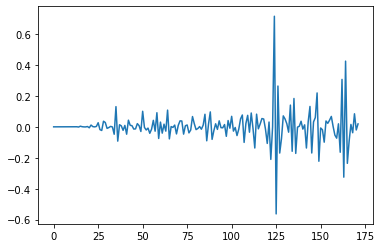

(102, 20)


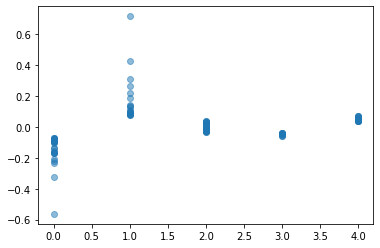

In [ ]:
alameda_data = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']

new_cases_1k_la_list = alameda_data['New Cases/1k population'].values
diffArr = np.diff(new_cases_1k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_1k_la_list = alameda_data['New Cases/1k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'flat_growth']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()
